# Advanced Raster Analysis

## Learning objectives
- Carry out a supervised classification on a SpatRaster
- Construct a raster sieve using the patches() function
- Deal with thematic (categorical maps)

# Introduction to Sentinel-2 data used here

We will carry out a supervised classification using Sentinel 2 data for the Gewata region in Ethiopia. To do this, we use atmospherically corrected Level 2A data acquired on December 27, 2020. These data were downloaded from ESA’s online data hub, a part of the Copernicus European Programme. As it is freely available, Sentinel data has been commonly used next to Landsat data for environmental monitoring.

![Landsat.v.Sentinel-2](../figs/Landsat.v.Sentinel-2.jpg)

# Notebook Setup

In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd

# raster processing
import rasterio as rio
from rasterio import Affine # or from affine import Affine
from rasterio.mask import mask
from shapely.geometry import mapping, Point
# from shapely.plotting import plot_polygon
import xarray as xr
import rioxarray as rxr

# viz
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns

# machine learning
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report #, accuracy_score
from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import train_test_split

# misc
from tqdm.auto import tqdm

# additional
from src.utils import *

In [2]:
ROOT_DIR = Path(os.getcwd()).parent
DATA_DIR = ROOT_DIR / 'data'

PYTHON_DIR = ROOT_DIR / 'python'
PYTHON_DATA_DIR = PYTHON_DIR / 'data'

In [3]:
raster_path = PYTHON_DATA_DIR / 'S2B2A_T36NZP_20201227T075239_20m_gewata_crop.tif' # the path to your imagery (raster)
bands_file_path = PYTHON_DATA_DIR / "S2B2A_T36NZP_20201227T075239_20m_gewata_bands.txt"

# Data exploration
Download the data to your computer and open your preferred ~~R IDE~~ to the directory of this tutorial.

After downloading the data we begin with visualization. The data consists of all the Sentinel-2 bands at a spatial resolution (or pixel size) of 20 m, meaning that each pixel on the scene corresponds to a ground distance of 20 m by 20 m. We will also make use of training polygons for the land cover classification, which will be introduced later.

In [4]:
with open(bands_file_path, "r") as f:
    band_names = f.readlines()
band_names = [name.strip() for name in band_names]

gewata = rxr.open_rasterio(raster_path)
gewata

<xarray.DataArray (band: 10, y: 1362, x: 2322)> Size: 63MB
[31625640 values with dtype=int16]
Coordinates:
  * band         (band) int64 80B 1 2 3 4 5 6 7 8 9 10
  * x            (x) float64 19kB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
  * y            (y) float64 11kB 8.495e+05 8.494e+05 ... 8.223e+05 8.222e+05
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
# Convert DataArray to Dataset
gewata_ds = gewata.to_dataset(dim="band")

# Get the original band names
original_band_names = gewata.band.values

# Rename the data variables
rename_dict = {original_band_names[i]: band_names[i] for i in range(len(original_band_names))}
gewata_ds = gewata_ds.rename(rename_dict)

In [6]:
# Sanity check, look at the "data variables", if the renaming is successful, the data variables will be the same as the band names
gewata_ds

<xarray.Dataset> Size: 63MB
Dimensions:      (y: 1362, x: 2322)
Coordinates:
  * x            (x) float64 19kB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
  * y            (y) float64 11kB 8.495e+05 8.494e+05 ... 8.223e+05 8.222e+05
    spatial_ref  int64 8B 0
Data variables:
    B02          (y, x) int16 6MB ...
    B03          (y, x) int16 6MB ...
    B04          (y, x) int16 6MB ...
    B05          (y, x) int16 6MB ...
    B06          (y, x) int16 6MB ...
    B07          (y, x) int16 6MB ...
    B11          (y, x) int16 6MB ...
    B12          (y, x) int16 6MB ...
    B8A          (y, x) int16 6MB ...
    SCL          (y, x) int16 6MB ...
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [6]:
# Convert Dataset back to DataArray
gewata = gewata_ds.to_array(dim="band")

# The image is cloud-free, so drop the cloud mask layer
gewata = gewata.drop_sel(band="SCL")

## Bands' value distribution

In [ ]:
# Calculate number of rows and columns for subplots
num_bands = len(gewata.band)
num_cols = 3  # Adjust the number of columns as desired
num_rows = (num_bands + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(
    num_rows,
    num_cols,
    figsize=(15, 3*num_rows),
    # sharex=True,
    sharey=True
    )

# Flatten axes if needed
axes = axes.flatten()

# Plot histograms for each band
for i, band in enumerate(gewata):
    ax = axes[i]
    ax.hist(band.values.ravel(), bins=50)
    
    # Add a vertical line for the mean
    mean_value = band.mean().values
    ax.axvline(mean_value, color='r', linestyle='--', label=f'Mean: {mean_value:.2f}')
    # ax.legend()
    
    ax.set_title(f'Histogram of {band.band.values}')
    if i % num_cols == 0:
        ax.set_ylabel('Frequency')
    if i >= num_bands - num_cols:
        ax.set_xlabel('Pixel Value')

plt.tight_layout()
plt.show()

![q1_histogram](./figure/q1_1_histogram.png)

In [8]:
# Calculate summary statistics for all bands
summary_data = []
for band in gewata:
    summary_data.append({
        "Band": band.band.values.item(),
        "Mean": float(band.mean().values),
        "Std Dev": float(band.std().values),
        "Min": float(band.min().values),
        "Max": float(band.max().values)
    })

# Convert summary data to DataFrame
summary_df = pd.DataFrame(summary_data)

# Print the summary DataFrame
print("Summary Statistics for all Bands:")
summary_df

Summary Statistics for all Bands:


,Band,Mean,Std Dev,Min,Max
0,B02,320.891652,96.878144,28.0,4466.0
1,B03,523.778370,146.013377,41.0,5115.0
2,B04,404.278885,194.292647,33.0,5365.0
3,B05,864.573163,235.896180,91.0,4989.0
4,B06,2250.752617,407.851255,257.0,8790.0
5,B07,2759.374131,516.482874,326.0,10546.0
6,B11,1725.436172,433.437046,194.0,6982.0
7,B12,908.699626,351.494109,41.0,14146.0
8,B8A,3042.925266,545.979949,172.0,11008.0


Note that the values of these bands have been rescaled by a factor of 10,000. This is done for file storage considerations. For example, a value of 0.5643 stored as a float takes up more disk space than a value of 5643 stored as an integer. If you prefer reflectance values in their original scale (from 0 to 1), ~~this can easily be done using raster algebra or app(). We will do this later~~.

In [9]:
# convert DataSet into pandas DataFrame
gewata_df = gewata_ds.to_dataframe()

# from all the raster value, randomly pick 1000 cells from each bands
sampled_df = gewata_df.sample(n=1000, random_state=42)
sampled_df = sampled_df.drop(columns=['SCL', 'spatial_ref']) # drop unused column for visualization

In [ ]:
g = sns.PairGrid(sampled_df)
g.map_diag(sns.histplot)
g.map_lower(sns.histplot)
g.map_upper(reg_coef)

![q1_pairplot](./figure/q1_2_pairplot.png)

<div class="alert alert-block alert-success">
<h2><b>Question 1:</b> Given what we know about the location of these bands along the EM spectrum, how could these scatterplots be explained?</h2>
</div>

<details>
<summary>Click to see answer.</summary>

Starting with bands 2 to 4, these correspond to the visible wavelengths of light, bands 5 and 6 are in the red edge region, 7, and 8a occupy the near infra-red (NIR) , while bands 11 and 12 are in the shortwave infrared (SWIR) region. An abrupt change occurs in the red to near infra-red region from around 680 to 800in our case this is demonstrated by the high variance and low correlation between bands 5 and 6.

</details>

In the [previous tutorial](https://geoscripting-wur.github.io/IntroToRaster/index.html#subsetting-layers-from-spatraster), we explored two ways to calculate NDVI, using direct raster algebra or using app(). Since we will be using NDVI again later in this tutorial, let’s calculate it again and store it in our workspace ~~using app()~~.

In [7]:
# Assuming your data has NIR and Red bands named 'NIR' and 'Red' respectively
nir_band = gewata.sel(band="B8A")
red_band = gewata.sel(band="B04")

# Calculate NDVI
ndvi = (nir_band - red_band) / (nir_band + red_band)

# Add a 'band' coordinate to the NDVI DataArray
ndvi = ndvi.expand_dims({'band': ['NDVI']}, axis=0) 

In [ ]:
# Plot NDVI
plt.figure(figsize=(10, 6))
ndvi.squeeze().plot.imshow(cmap='RdYlGn')
plt.title('NDVI')
plt.yticks(rotation=90) # Reorient y-axis tick labels
plt.show()

![q2_ndvi](./figure/q2_ndvi.png)

<div class="alert alert-block alert-success">
<h2><b>Question 2:</b> What is the advantage of including the NDVI layer in the land cover classification?</h2>
Hint: For information on NDVI, check out <a href="https://gisgeography.com/ndvi-normalized-difference-vegetation-index/" target="_blank">this source</a>.
</div>

<details>
<summary>Click to see answer.</summary>
It adds additional information which the model could use to classify the pixels.
</details>

# Classifying raster data

One of the most important tasks in analysis of remote sensing image analysis is image classification. In classifying the image, we take the information contained in the various bands (possibly including other synthetic bands such as NDVI or principal components). There are two approaches for image classification: supervised and unsupervised. In this tutorial we will explore supervised classification based on the Random Forest method.

## Supervised classification: Random Forest

The Random Forest classification algorithm is an ensemble learning method that is used for both classification and regression. In our case, we will use the method for classification purposes. Here, the Random Forest method takes random subsets from a training dataset and constructs classification trees using each of these subsets. Trees consist of branches and leaves.

Branches represent nodes of the decision trees, which are often thresholds defined for the measured (known) variables in the dataset. Leaves are the class labels assigned at the termini of the trees. Sampling many subsets at random will result in many trees being built. Classes are then assigned based on classes assigned by all of these trees based on a majority rule, as if each class assigned by a decision tree were considered to be a vote.

The figure below gives a simple demonstration of how the random forest method works in principle. For an introduction to the Random Forest algorithm, see this [presentation](https://www.slideshare.net/0xdata/jan-vitek-distributedrandomforest522013). For more information on ~~random forest implementation in R see this tutorial~~.

![randomForestDescription](../figs/randomForestDescription.png)

One major advantage of the Random Forest method is the fact that an Out Of the Bag (OOB) cross-validation error estimate and an estimate of variable performance are performed. For each classification tree assembled, a fraction of the training data are left out and used to compute the error for each tree by predicting the class associated with that value and comparing with the already known class. This process results in a confusion matrix, which we will explore in our analysis. In addition an importance score is computed for each variable in two forms: the mean decrease in accuracy for each variable, and the Gini impurity criterion, which will also be explored in our analysis.

~~To perform the classification in R, it is best to assemble all covariate layers (ie. those layers containing predictor variable values) into one SpatRaster object. In this case, we can simply append the new layer (NDVI) to our existing SpatRaster (currently consisting of different bands)~~.

First, let’s rescale the original reflectance values to their original scale. This step is not required for the RF classification, but it might help with the interpretation, if you are used to thinking of reflectance as a value between 0 and 1. (On the other hand, for very large raster bricks, it might be preferable to leave them in their integer scale, but we won’t go into more detail about that here.)

In [9]:
# add ndvi band to original raster
gewata_with_ndvi = xr.concat([gewata, ndvi], dim='band')

# rescaling
gewata_with_ndvi = gewata_with_ndvi / 10000

# gewata_with_ndvi

In [10]:
# saving the raster, we will need this for data preparation process
ndvi_raster_name = "gewata_with_ndvi.tif"
ndvi_raster_path = PYTHON_DATA_DIR / ndvi_raster_name

if not os.path.exists(ndvi_raster_path):
    print('saving....')
    gewata_with_ndvi.rio.to_raster(PYTHON_DATA_DIR / "gewata_with_ndvi.tif")
    print(f'saved to {ndvi_raster_path}') 
else:
    print(f'{ndvi_raster_path} already exists, skipping process...')

/home/amrirasyidi/projects/1_learn/AdvancedRasterAnalysis/python/data/gewata_with_ndvi.tif already exists, skipping process...


## Training data preparation
For this exercise, we will do a very simple classification for 2020 using three classes: forest, cropland and wetland. While for other purposes it is usually better to define more classes (and possibly fuse classes later), a simple classification like this one could be useful, for example, to construct a forest mask for the year 2020.

In [12]:
training_polygons = gpd.read_file(DATA_DIR / 'trainingPoly.csv')
training_polygons = training_polygons.set_crs(gewata_with_ndvi.rio.crs)
training_polygons = training_polygons.drop(columns=[
    'WKT',
    # 'Code'
    ]) # Drop WKT column as it is redundant with geometry column
training_polygons.head(3)

,OBJECTID,Class,geometry
0,1,wetland,"POLYGON ((821935.575 833523.320, 823504.654 83..."
1,2,wetland,"POLYGON ((824714.007 831022.839, 827669.137 83..."
2,3,wetland,"POLYGON ((830913.385 832637.370, 831328.993 83..."


Text(0.5, 1.0, 'Overlay Plot')

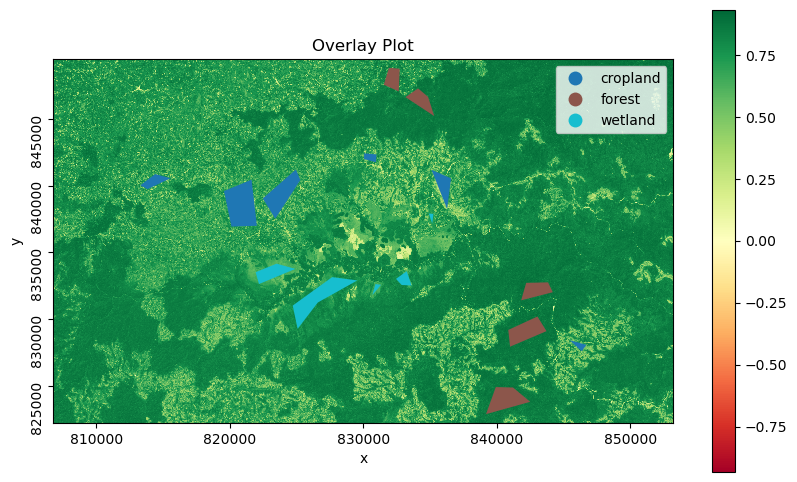

In [16]:
# Plot NDVI
fig, ax = plt.subplots(figsize=(10, 6))

ndvi.squeeze().plot.imshow(ax=ax, cmap='RdYlGn')
training_polygons.plot(
    column='Class',
    legend=True,
    ax=ax
    )

plt.yticks(rotation=90) # Reorient y-axis tick labels
plt.title('Overlay Plot')

The training classes are labelled as string labels. For this exercise, we will need to work with integer classes, so we will need to first ‘relabel’ our training classes. There are several approaches that could be used to convert these classes to integer codes.

In [13]:
# Convert the 'Class' column to a categorical dtype (factor in R)
training_polygons['Class'] = training_polygons['Class'].astype('category')

# Check summary statistics of the 'Class' column after conversion
training_polygons['Class'].describe()

count           16
unique           3
top       cropland
freq             6
Name: Class, dtype: object

In [14]:
# Make a new 'Code' column by converting the factor levels to integers
training_polygons['Code'] = training_polygons['Class'].cat.codes

# Inspect the new 'Code' column
training_polygons['Code'].describe()

count    16.000000
mean      0.937500
std       0.853913
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       2.000000
Name: Code, dtype: float64

<Axes: title={'center': 'band = NDVI, spatial_ref = 0'}, xlabel='x', ylabel='y'>

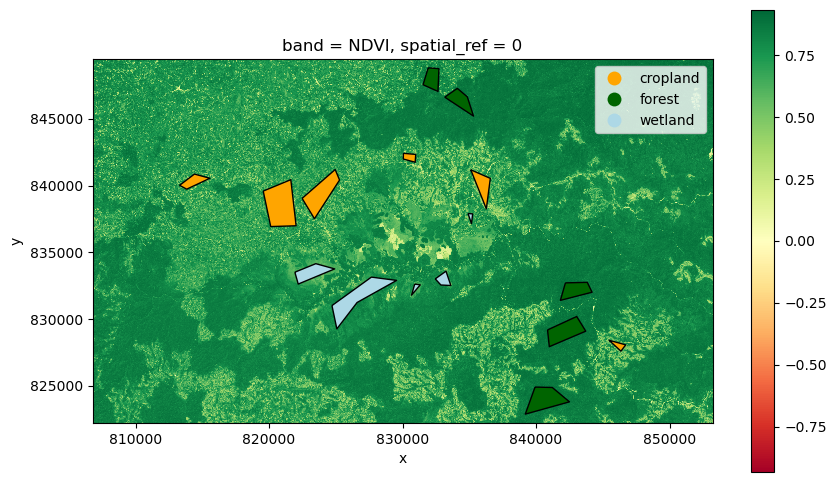

In [19]:
# Superimpose training polygons (color by class) onto NDVI plot
fig, ax = plt.subplots(figsize = (10,6))

ndvi.squeeze().plot.imshow(ax=ax, cmap='RdYlGn')

# Define a colour scale for the classes (as above) corresponding to: cropland, forest, wetland
color_dict = {
    "cropland":"orange",
    "forest":"darkgreen",
    "wetland":"lightblue"
    }

training_polygons.plot(
    column='Class',
    ax=ax,
    legend=True,
    cmap=colors.ListedColormap(list(color_dict.values())),
    edgecolor='black'
    )

Our goal in preprocessing this data is to have a table of values representing all layers (covariates) with known values/classes. To do this, we will first need to know the values of the covariates at our training polygon locations. ~~We can use extract function of terra package for this. Next we convert these data to a data.frame representing all training data~~.

In [15]:
# https://gis.stackexchange.com/a/260380/140116

new_band_names = gewata_with_ndvi.band.values.tolist()
geoms_list = training_polygons.geometry.values
class_list = training_polygons.Class.values
code_list = training_polygons.Code.values

# for each polygon, extract the raster values
gdf_list = []
for geometry, _class, _code in tqdm(zip(geoms_list, class_list, code_list), total=len(code_list)):
    band_val_list = []

    # for each bands extract the raster value to the polygon
    for i, band in enumerate(new_band_names):
        geoms_shp = [mapping(geometry)]

        with rio.open(ndvi_raster_path) as src:
            out_image, out_transform = mask(src, geoms_shp, crop=True)

        if src.nodata!=None:
            no_data=src.nodata
        else:
            no_data=0

        band_values = out_image[i]

        row, col = np.where(band_values!=no_data)
        band_val_clipped = np.extract(band_values!=no_data, band_values)

        d = pd.DataFrame({
            'row':row,
            'col':col,
            'class':_class,
            'code':_code,
            band:band_val_clipped
            })
        band_val_list.append(d)

    semi_final_gdf = pd.concat(band_val_list, axis=1)
    semi_final_gdf = semi_final_gdf.loc[:,~semi_final_gdf.columns.duplicated()].copy() # https://stackoverflow.com/a/40435354/9782019

    gdf_list.append(semi_final_gdf)

training_label = pd.concat(gdf_list)

# coordinate transformation
T1 = out_transform * Affine.translation(0.5, 0.5) # reference the pixel centre
rc2xy = lambda r, c: T1 * (c, r) # row col to xy

training_label['x'] = training_label.apply(lambda row: rc2xy(row.row,row.col)[0], axis=1)
training_label['y'] = training_label.apply(lambda row: rc2xy(row.row,row.col)[1], axis=1)

# add geometry
training_label = gpd.GeoDataFrame(
    training_label,
    geometry=gpd.points_from_xy(training_label.x, training_label.y),
    crs=training_polygons.crs
    )

training_label = training_label.sort_values(by=['row','col']).reset_index().drop(columns=['index'])

  0%|          | 0/16 [00:00<?, ?it/s]

This data.frame will be used as an input into the RandomForest classification function. Let’s inspect the data.

In [24]:
training_label.head()

,row,col,class,code,B02,B03,B04,B05,B06,B07,B11,B12,B8A,NDVI,x,y,geometry
0,0,0,wetland,2,0.0379,0.0672,0.0513,0.1116,0.2604,0.3130,0.1891,0.0964,0.3548,0.000075,845450.0,828430.0,POINT (845450.000 828430.000)
1,0,1,wetland,2,0.0372,0.0665,0.0548,0.1104,0.2433,0.2921,0.2001,0.1046,0.3376,0.000072,845470.0,828430.0,POINT (845470.000 828430.000)
2,0,2,wetland,2,0.0371,0.0685,0.0545,0.1135,0.2565,0.3030,0.2097,0.1129,0.3476,0.000073,845490.0,828430.0,POINT (845490.000 828430.000)
3,0,3,wetland,2,0.0386,0.0686,0.0533,0.1138,0.2602,0.3119,0.2069,0.1076,0.3603,0.000074,845510.0,828430.0,POINT (845510.000 828430.000)
4,0,4,wetland,2,0.0381,0.0664,0.0528,0.1116,0.2546,0.3060,0.2020,0.1045,0.3470,0.000074,845530.0,828430.0,POINT (845530.000 828430.000)


In [25]:
training_label.tail()

,row,col,class,code,B02,B03,B04,B05,B06,B07,B11,B12,B8A,NDVI,x,y,geometry
87199,190,20,wetland,2,0.0391,0.0704,0.0423,0.1058,0.3120,0.3833,0.1860,0.0851,0.4131,0.000081,845850.0,824630.0,POINT (845850.000 824630.000)
87200,190,21,wetland,2,0.0353,0.0627,0.0377,0.1002,0.2781,0.3100,0.1724,0.0847,0.3532,0.000081,845870.0,824630.0,POINT (845870.000 824630.000)
87201,191,19,wetland,2,0.0401,0.0738,0.0392,0.1135,0.3689,0.4349,0.1961,0.0902,0.4721,0.000085,845830.0,824610.0,POINT (845830.000 824610.000)
87202,191,20,wetland,2,0.0417,0.0715,0.0411,0.1058,0.3302,0.4128,0.1893,0.0855,0.4472,0.000083,845850.0,824610.0,POINT (845850.000 824610.000)
87203,192,19,wetland,2,0.0398,0.0703,0.0395,0.1073,0.3339,0.4025,0.1944,0.0885,0.4385,0.000083,845830.0,824590.0,POINT (845830.000 824590.000)


In [26]:
training_label.describe().T

,count,mean,std,min,25%,50%,75%,max
row,87204.0,62.389397,41.762706,0.000000,30.000000,53.000000,87.000000,192.000000
col,87204.0,65.623618,39.839297,0.000000,35.000000,59.000000,90.000000,241.000000
code,87204.0,0.835787,0.786837,0.000000,0.000000,1.000000,1.000000,2.000000
B02,87204.0,0.033530,0.010571,0.010000,0.022300,0.036300,0.041400,0.167900
B03,87204.0,0.055077,0.015250,0.014200,0.040600,0.057400,0.068300,0.192400
B04,87204.0,0.043317,0.019787,0.010200,0.023500,0.043600,0.056400,0.211000
B05,87204.0,0.090408,0.022901,0.025300,0.069400,0.095000,0.107900,0.233800
B06,87204.0,0.222709,0.040233,0.068600,0.196200,0.216800,0.243500,0.391000
B07,87204.0,0.270197,0.050208,0.088500,0.236100,0.264000,0.297900,0.502100
B11,87204.0,0.177384,0.047174,0.059200,0.135200,0.179400,0.208000,0.392200


In [27]:
training_label.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 87204 entries, 0 to 87203
Data columns (total 17 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   row       87204 non-null  int64   
 1   col       87204 non-null  int64   
 2   class     87204 non-null  object  
 3   code      87204 non-null  int8    
 4   B02       87204 non-null  float64 
 5   B03       87204 non-null  float64 
 6   B04       87204 non-null  float64 
 7   B05       87204 non-null  float64 
 8   B06       87204 non-null  float64 
 9   B07       87204 non-null  float64 
 10  B11       87204 non-null  float64 
 11  B12       87204 non-null  float64 
 12  B8A       87204 non-null  float64 
 13  NDVI      87204 non-null  float64 
 14  x         87204 non-null  float64 
 15  y         87204 non-null  float64 
 16  geometry  87204 non-null  geometry
dtypes: float64(12), geometry(1), int64(2), int8(1), object(1)
memory usage: 10.7+ MB


We have our training dataset as a ~~data.frame~~ with the class column as a factor. If it is integer, random forest regression will be run, instead of classification. So, good to check on that.

Now we have a convenient training data table which contains, for each of the three defined classes, values for all covariates. Let’s visualize the distribution of some of these covariates for each class. To make this easier, we will create 3 different ~~data.frames~~ for each of the classes. This is just for plotting purposes, and we will not use these in the actual classification.

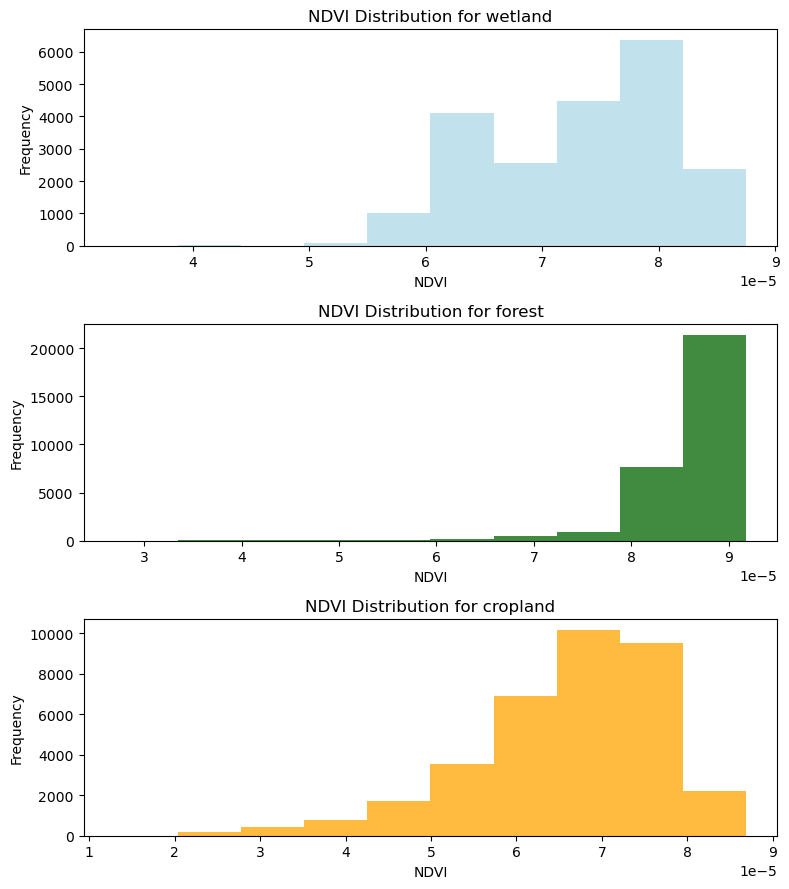

In [25]:
# Unique classes in the 'class' column
classes = training_label['class'].unique()

# Number of unique classes
n_classes = len(classes)

# Define your color mapping based on the class order
class_colors = {
    'wetland': 'lightblue',  # Replace 'Class 1' with your actual class name if different
    'forest': 'darkgreen',
    'cropland': 'orange'
}

# Create a figure and axes with a grid of subplots
fig, axs = plt.subplots(nrows=n_classes, figsize=(8, 3 * n_classes))

# Check if there's only one class to adjust indexing
if n_classes == 1:
    axs = [axs]

# Plot a histogram for each class
for ax, cls in zip(axs, classes):
    # Select NDVI data for the current class
    subset = training_label[training_label['class'] == cls]['NDVI']
    
    # Plot histogram
    ax.hist(
        subset,
        # bins=30,
        color=class_colors[cls],
        alpha=0.75,
        label=f'Class {cls} NDVI'
        )
    
    # Set title and labels
    ax.set_title(f'NDVI Distribution for {cls}')
    ax.set_xlabel('NDVI')
    ax.set_ylabel('Frequency')
    
    # # Add a legend
    # ax.legend()

# Adjust layout
plt.tight_layout()

Note that other covariates such as the bands can also be plotted like above.

We can also create useful scatterplots this way:

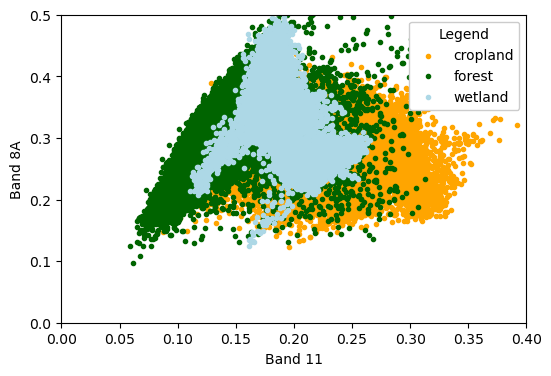

In [25]:
val_crop = training_label[training_label['class']=='cropland'][['B11', 'B8A']]
val_forest = training_label[training_label['class']=='forest'][['B11', 'B8A']]
val_wetland = training_label[training_label['class']=='wetland'][['B11', 'B8A']]

# Create a scatter plot
plt.figure(figsize=(6, 4))

# Scatter plots for each class
plt.scatter(val_crop['B11'], val_crop['B8A'], c='orange', marker='.', label='cropland')
plt.scatter(val_forest['B11'], val_forest['B8A'], c='darkgreen', marker='.', label='forest')
plt.scatter(val_wetland['B11'], val_wetland['B8A'], c='lightblue', marker='.', label='wetland')

# Setting the limits for X and Y axes
plt.xlim(0, 0.4)
plt.ylim(0, 0.5)

# Adding labels
plt.xlabel('Band 11')
plt.ylabel('Band 8A')

# Adding a legend
plt.legend(title='Legend', loc='upper right', frameon=True, framealpha=1, facecolor='white')

<div class="alert alert-block alert-success">
<h2><b>Question 3:</b> Try to produce the same scatterplot plot as above looking at the relationship between other bands. Try B02 & B05, B07 & NDVI (you might have adjust the xlim to incorporate the NDVI values) and another of your choice. What can you say about the relationships between these bands? Which ones give a clear distinction between classes, and where is this less clear?</h2>
</div>

<details>
<summary>Click to see answer.</summary>
LOL
</details>

We can see from these distributions that these covariates may do well in classifying forest pixels, but we may expect some confusion between cropland and wetland (although the individual bands may help to separate these classes). You can save the training data using the ~~write.csv()~~ command, in case something goes wrong after this point and you need to start over again.

In [25]:
training_out_name = 'final_training_label_gdf.gpkg'
if not os.path.exists(PYTHON_DATA_DIR / training_out_name):
    print('saving....')
    training_label.to_file(PYTHON_DATA_DIR / training_out_name, driver='GPKG')
    print(f'saved to {PYTHON_DATA_DIR / training_out_name}') 
else:
    print(f'{PYTHON_DATA_DIR / training_out_name} already exists,\nreading the file...')
    training_label = gpd.read_file(PYTHON_DATA_DIR / training_out_name)
    new_band_names = gewata_with_ndvi.band.values.tolist()

/home/amrirasyidi/projects/1_learn/AdvancedRasterAnalysis/python/data/final_training_label_gdf.gpkg already exists,
reading the file...


## Run Random Forest classification
We build the Random Forest model using the training data. For this, we will use the ~~ranger package in R. There is also randomForest package available in R. However, ranger is is implemented in C++ with multithreading and thus is much faster. Using the ranger() function,~~ we will build a model based on a matrix of predictors or covariates (ie. the first 10 columns of trainingData) related to the response (the Class column of trainingData).

## Construct a random forest model.
Covariates (x) are found in ~~columns 1 to 10 of trainingData~~. Training classes (y) are found in the ‘Class’ column of trainingData. Caution: this step takes fairly long! but can be shortened ~~by limiting the number of trees to 100 and by setting importance = FALSE~~.

In [17]:
# define a random seed to ensure reproducibility
RANDOM_SEED = 42

# Separate features and target variable
X = training_label[new_band_names]  # Assuming the last column is the target
y = training_label['class']

# Initialize the RandomForestClassifier
modelRF = RandomForestClassifier(
    n_estimators=100,
    random_state=RANDOM_SEED,
    oob_score=True,
    criterion='gini',
    n_jobs=-1
    )

# Fit the model on the training data
modelRF.fit(X, y)

RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

Since the random forest method involves the building and testing of many classification trees (the ‘forest’), it is a computationally expensive step (and could take a lot of memory for especially large training datasets). When this step is finished, it would be a good idea to save the resulting object with the saveRDS() command. Any R object can be saved as an .rds file and reloaded into future sessions using readRDS().

<div class="alert alert-info">
<b>Note:</b> there is a similar functionality using the <s><code>save()</code> and load() commands, but those can save more than one object and don’t tell you their names, you have to know them. That is why saveRDS()/readRDS() is preferred</s>, but in this tutorial in a lot of cases load is still being used.
</div>


The resulting object from the ranger() function is a specialized object of class ranger, which is a large list-type object packed full of information about the model output. Elements of this object can be called and inspected like any list object.

In [18]:
# Inspect the Out-Of-Bag prediction error
print("OOB Score:", 1 - modelRF.oob_score_)

OOB Score: 0.03328975735058026


In [19]:
# Calculate the overall accuracy
print("Overall Accuracy:", modelRF.oob_score_)

Overall Accuracy: 0.9667102426494197


In [20]:
training_label.head(2)

,row,col,class,code,B02,B03,B04,B05,B06,B07,B11,B12,B8A,NDVI,x,y,geometry
0,0,0,wetland,2,0.0379,0.0672,0.0513,0.1116,0.2604,0.3130,0.1891,0.0964,0.3548,0.000075,845450.0,828430.0,POINT (845450.000 828430.000)
1,0,1,wetland,2,0.0372,0.0665,0.0548,0.1104,0.2433,0.2921,0.2001,0.1046,0.3376,0.000072,845470.0,828430.0,POINT (845470.000 828430.000)


              precision    recall  f1-score   support

    cropland       0.95      0.97      0.96     35330
      forest       0.99      0.96      0.97     30864
     wetland       0.97      0.96      0.97     21010

    accuracy                           0.97     87204
   macro avg       0.97      0.97      0.97     87204
weighted avg       0.97      0.97      0.97     87204



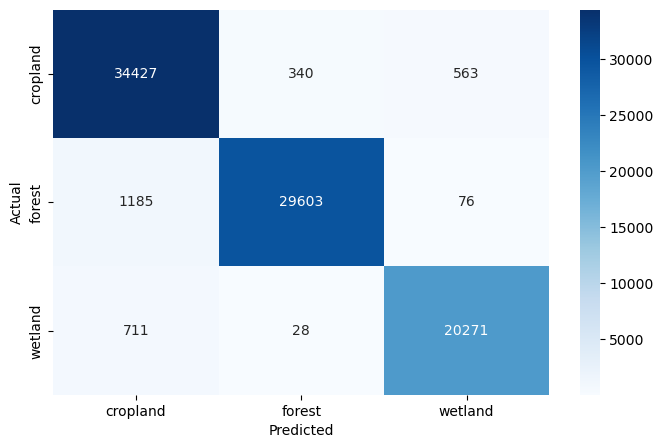

In [19]:
# Inspect the confusion matrix of the OOB error assessment
oob_predictions = modelRF.oob_decision_function_
predicted_classes = oob_predictions.argmax(axis=1)
predicted_labels = [modelRF.classes_[i] for i in predicted_classes]

encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)  # This will convert categories to numbers

cm = confusion_matrix(
    y_encoded,
    predicted_classes,
    # labels=modelRF.classes_
    )

print(classification_report(
    y_encoded,
    predicted_classes,
    target_names=modelRF.classes_.tolist()
    ))

plt.figure(figsize=(8,5))
sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=modelRF.classes_,
    yticklabels=modelRF.classes_,
    cmap='Blues',
)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The overall accuracy and the confusion matrix are often used to evaluate the results of a supervised classification. However, the confusion matrix can provide more detailed information by giving per-class accuracies.

<div class="alert alert-info">
<b>Note</b>: If you wish to learn how to read a confusion matrix, check out this <a href="https://www.evidentlyai.com/classification-metrics/confusion-matrix">tutorial</a>.
</div>

Earlier we provided a brief explanation of OOB error, though it can be a valuable metric for evaluating your model, it can overestimate the true prediction error depending on the parameters presents in the model.

Since we set importance = "permutation", we now also have information on the statistical importance of each of our covariates which we can retrieve using the importance() command.

In [21]:
# Display feature importance
print("Feature Importances:")
pd.DataFrame(modelRF.feature_importances_.reshape(1,-1), columns=new_band_names)

Feature Importances:


,B02,B03,B04,B05,B06,B07,B11,B12,B8A,NDVI
0,0.244057,0.090599,0.165485,0.048304,0.047829,0.057101,0.091077,0.18176,0.059226,0.014562


The above shows the variable importance for a Random Forest model showing the mean decrease in accuracy for each variable.

The mean decrease in accuracy indicates the amount by which the classification accuracy decreased based on the OOB assessment. ~~In this case, it seems that Gewata bands 2, 4 and 12 have the highest impact on accuracy~~. For large datasets, it may be helpful to know this information, and leave out less important variables for subsequent runs of the ranger() function.

Since the NDVI layer scores relatively low according to the mean accuracy decrease criterion, try to construct an alternate Random Forest model as above, but excluding this layer, you can name it something like ‘modelRF2’.

<div class="alert alert-block alert-success">
<h2><b>Question 4:</b> What effect does this have on the accuracy of the results? </h2>
Hint: Compare the overall accuracies (or the confusion matrices) of the original and new outputs.
</div>

<details>
<summary>Click to see answer.</summary>
LOL
</details>

<div class="alert alert-block alert-success">
<h2><b>Question 5:</b> What effect does leaving this variable out have on the processing time?</h2>
Hint: Use system.time().
</div>

<details>
<summary>Click to see answer.</summary>
LOL
</details>

Now we apply this model to the rest of the image and assign classes to all pixels. Note that for this step, the names of the layers in the input SpatRaster (here covs) must correspond exactly to the column names of the training table. We will use the predict() function from the terra package. This function uses a pre-defined model to predict values of raster cells based on a SpatRaster. This model can be derived by a linear regression, for example. In our case, we will use the model provided by the ranger() function.

In [21]:
# Double-check layer and column names to make sure they match
print(gewata_with_ndvi.band.values)
print(new_band_names)

['B02' 'B03' 'B04' 'B05' 'B06' 'B07' 'B11' 'B12' 'B8A' 'NDVI']
['B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B11', 'B12', 'B8A', 'NDVI']


In [22]:
# Convert the DataArray to a DataFrame
test_df = gewata_with_ndvi.to_dataframe(name="value").reset_index()
test_df = test_df.pivot(index=['y', 'x'], columns='band', values='value').reset_index()

# Create a GeoDataFrame
# Now 'gdf' is a GeoDataFrame with each point representing the value from the raster
test_gdf = gpd.GeoDataFrame(
    test_df, 
    geometry=[Point(xy) for xy in zip(test_df.x, test_df.y)], 
    crs=gewata_with_ndvi.rio.crs
)

In [23]:
test_gdf.head()

band,y,x,B02,B03,B04,B05,B06,B07,B11,B12,B8A,NDVI,geometry
0,822250.0,806790.0,0.0267,0.0419,0.0231,0.0685,0.2291,0.2991,0.1209,0.0542,0.3141,0.000086,POINT (806790.000 822250.000)
1,822250.0,806810.0,0.0264,0.0435,0.0233,0.0703,0.2107,0.2682,0.1257,0.0492,0.2976,0.000085,POINT (806810.000 822250.000)
2,822250.0,806830.0,0.0286,0.0546,0.0294,0.0819,0.2567,0.3351,0.1425,0.0609,0.3466,0.000084,POINT (806830.000 822250.000)
3,822250.0,806850.0,0.0289,0.0446,0.0264,0.0753,0.2324,0.3095,0.1447,0.0596,0.3461,0.000086,POINT (806850.000 822250.000)
4,822250.0,806870.0,0.0287,0.0418,0.0265,0.0637,0.2383,0.2907,0.1301,0.0587,0.3079,0.000084,POINT (806870.000 822250.000)


In [24]:
test_gdf.describe().T

,count,mean,std,min,25%,50%,75%,max
band,,,,,,,,
y,3162564.0,835860.000000,7863.509790,822250.000000,829050.000000,835860.00000,842670.000000,849470.000000
x,3162564.0,830000.000000,13406.074127,806790.000000,818390.000000,830000.00000,841610.000000,853210.000000
B02,3162564.0,0.032089,0.009688,0.002800,0.024800,0.03140,0.038700,0.446600
B03,3162564.0,0.052378,0.014601,0.004100,0.041200,0.04980,0.063000,0.511500
B04,3162564.0,0.040428,0.019429,0.003300,0.026000,0.03350,0.052300,0.536500
B05,3162564.0,0.086457,0.023590,0.009100,0.067800,0.08120,0.104300,0.498900
B06,3162564.0,0.225075,0.040785,0.025700,0.198000,0.22260,0.249900,0.879000
B07,3162564.0,0.275937,0.051648,0.032600,0.241700,0.27330,0.307800,1.054600
B11,3162564.0,0.172544,0.043344,0.019400,0.139800,0.16570,0.201700,0.698200


In [27]:
test_out_name = 'final_test_gdf.gpkg'
if not os.path.exists(PYTHON_DATA_DIR / test_out_name):
    print('saving....')
    test_gdf.to_file(PYTHON_DATA_DIR / test_out_name, driver='GPKG')
    print(f'saved to {PYTHON_DATA_DIR / test_out_name}') 
else:
    print(f'{PYTHON_DATA_DIR / test_out_name} already exists,\nreading the file...')
    test_gdf = gpd.read_file(PYTHON_DATA_DIR / test_out_name)
    new_band_names = gewata_with_ndvi.band.values.tolist()

/home/amrirasyidi/projects/1_learn/AdvancedRasterAnalysis/python/data/final_test_gdf.gpkg already exists,
reading the file...


In [28]:
predLC = modelRF.predict(test_gdf[new_band_names])

In [30]:
pred_gdf

,B02,B03,B04,B05,B06,B07,B11,B12,B8A,NDVI,pred,geometry,x,y
0,0.0379,0.0672,0.0513,0.1116,0.2604,0.3130,0.1891,0.0964,0.3548,0.000075,wetland,POINT (845450.000 828430.000),845450.0,828430.0
1,0.0372,0.0665,0.0548,0.1104,0.2433,0.2921,0.2001,0.1046,0.3376,0.000072,wetland,POINT (845470.000 828430.000),845470.0,828430.0
2,0.0371,0.0685,0.0545,0.1135,0.2565,0.3030,0.2097,0.1129,0.3476,0.000073,wetland,POINT (845490.000 828430.000),845490.0,828430.0
3,0.0386,0.0686,0.0533,0.1138,0.2602,0.3119,0.2069,0.1076,0.3603,0.000074,wetland,POINT (845510.000 828430.000),845510.0,828430.0
4,0.0381,0.0664,0.0528,0.1116,0.2546,0.3060,0.2020,0.1045,0.3470,0.000074,wetland,POINT (845530.000 828430.000),845530.0,828430.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87199,0.0391,0.0704,0.0423,0.1058,0.3120,0.3833,0.1860,0.0851,0.4131,0.000081,wetland,POINT (845850.000 824630.000),845850.0,824630.0
87200,0.0353,0.0627,0.0377,0.1002,0.2781,0.3100,0.1724,0.0847,0.3532,0.000081,wetland,POINT (845870.000 824630.000),845870.0,824630.0
87201,0.0401,0.0738,0.0392,0.1135,0.3689,0.4349,0.1961,0.0902,0.4721,0.000085,wetland,POINT (845830.000 824610.000),845830.0,824610.0
87202,0.0417,0.0715,0.0411,0.1058,0.3302,0.4128,0.1893,0.0855,0.4472,0.000083,wetland,POINT (845850.000 824610.000),845850.0,824610.0


In [31]:
# convert prediction into a geodataframe

# prepare the band value dictionary
band_val_dict = {band_name: test_gdf[band_name].tolist() for band_name in new_band_names}
band_val_dict['pred'] = predLC.tolist() # add prediction result

# include ndvi value and pred_code, just because
pred_gdf = gpd.GeoDataFrame(
    band_val_dict,
    geometry=gpd.points_from_xy(test_gdf.x, test_gdf.y)
)

pred_gdf["x"] = pred_gdf.geometry.x
pred_gdf["y"] = pred_gdf.geometry.y

# Convert GeoDataFrame to xarray Dataset
pred_ds = pred_gdf.to_xarray()

In [39]:
pred_ds = pred_ds.set_index(index=['y', 'x'])

In [40]:
pred_ds

<xarray.Dataset> Size: 10MB
Dimensions:   (index: 87204)
Coordinates:
  * index     (index) object 698kB MultiIndex
  * y         (index) float64 698kB 8.284e+05 8.284e+05 ... 8.246e+05 8.246e+05
  * x         (index) float64 698kB 8.454e+05 8.455e+05 ... 8.458e+05 8.458e+05
Data variables:
    B02       (index) float64 698kB 0.0379 0.0372 0.0371 ... 0.0417 0.0398
    B03       (index) float64 698kB 0.0672 0.0665 0.0685 ... 0.0715 0.0703
    B04       (index) float64 698kB 0.0513 0.0548 0.0545 ... 0.0411 0.0395
    B05       (index) float64 698kB 0.1116 0.1104 0.1135 ... 0.1058 0.1073
    B06       (index) float64 698kB 0.2604 0.2433 0.2565 ... 0.3302 0.3339
    B07       (index) float64 698kB 0.313 0.2921 0.303 ... 0.4349 0.4128 0.4025
    B11       (index) float64 698kB 0.1891 0.2001 0.2097 ... 0.1893 0.1944
    B12       (index) float64 698kB 0.0964 0.1046 0.1129 ... 0.0855 0.0885
    B8A       (index) float64 698kB 0.3548 0.3376 0.3476 ... 0.4472 0.4385
    NDVI      (index) float64 698kB 7.474e-05 7.207e-05 ... 8.317e-05 8.347e-05
    pred      (index) object 698kB 'wetland' 'wetland' ... 'wetland' 'wetland'
    geometry  (index) object 698kB POINT (845450 828430) ... POINT (845830 82...

In [42]:
pred_ds.keys()

KeysView(<xarray.Dataset> Size: 10MB
Dimensions:   (index: 87204)
Coordinates:
  * index     (index) object 698kB MultiIndex
  * y         (index) float64 698kB 8.284e+05 8.284e+05 ... 8.246e+05 8.246e+05
  * x         (index) float64 698kB 8.454e+05 8.455e+05 ... 8.458e+05 8.458e+05
Data variables:
    B02       (index) float64 698kB 0.0379 0.0372 0.0371 ... 0.0417 0.0398
    B03       (index) float64 698kB 0.0672 0.0665 0.0685 ... 0.0715 0.0703
    B04       (index) float64 698kB 0.0513 0.0548 0.0545 ... 0.0411 0.0395
    B05       (index) float64 698kB 0.1116 0.1104 0.1135 ... 0.1058 0.1073
    B06       (index) float64 698kB 0.2604 0.2433 0.2565 ... 0.3302 0.3339
    B07       (index) float64 698kB 0.313 0.2921 0.303 ... 0.4349 0.4128 0.4025
    B11       (index) float64 698kB 0.1891 0.2001 0.2097 ... 0.1893 0.1944
    B12       (index) float64 698kB 0.0964 0.1046 0.1129 ... 0.0855 0.0885
    B8A       (index) float64 698kB 0.3548 0.3376 0.3476 ... 0.4472 0.4385
    NDVI      (inde

In [44]:
pred_ds.dims

FrozenMappingWarningOnValuesAccess({'index': 87204})

In [41]:
pred_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)

MissingSpatialDimensionError: x dimension (x) not found.

In [ ]:
pred_ds.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
pred_ds.rio.write_crs(test_gdf.crs, inplace=True)

In [31]:
pred_ds

<xarray.Dataset> Size: 380MB
Dimensions:   (index: 3162564)
Coordinates:
  * index     (index) int64 25MB 0 1 2 3 4 ... 3162560 3162561 3162562 3162563
Data variables: (12/14)
    B02       (index) float64 25MB 0.0267 0.0264 0.0286 ... 0.0189 0.0206 0.0251
    B03       (index) float64 25MB 0.0419 0.0435 0.0546 ... 0.0342 0.0356 0.0452
    B04       (index) float64 25MB 0.0231 0.0233 0.0294 ... 0.0226 0.0224 0.0275
    B05       (index) float64 25MB 0.0685 0.0703 0.0819 ... 0.061 0.0677 0.0836
    B06       (index) float64 25MB 0.2291 0.2107 0.2567 ... 0.2174 0.2269 0.2947
    B07       (index) float64 25MB 0.2991 0.2682 0.3351 ... 0.2569 0.3089 0.3745
    ...        ...
    B8A       (index) float64 25MB 0.3141 0.2976 0.3466 ... 0.2975 0.32 0.4105
    NDVI      (index) float64 25MB 8.63e-05 8.548e-05 ... 8.692e-05 8.744e-05
    pred      (index) object 25MB 'forest' 'forest' ... 'forest' 'forest'
    geometry  (index) object 25MB POINT (806790 822250) ... POINT (853210 849...
    x         (index) float64 25MB 8.068e+05 8.068e+05 ... 8.532e+05 8.532e+05
    y         (index) float64 25MB 8.222e+05 8.222e+05 ... 8.495e+05 8.495e+05

In [136]:
# # OPTIONAL: save to raster

# raster_pred_path = PYTHON_DATA_DIR / 'pred_raster.tif'
# if not os.path.exists(raster_pred_path):
#     pred_ds.rio.to_raster(raster_pred_path)

In [57]:
# Define the colors
cols = ['orange', 'darkgreen', 'lightblue']  # Colors corresponding to the classes

# Create a mapping from predicted classes to colors
class_to_color = {modelRF.classes_[i]: cols[i] for i in range(len(cols))}

# Map each prediction to a color
colors = [class_to_color[cls] for cls in predLC]

In [60]:
plt.figure(figsize=(10, 1))  # Adjust size as needed
plt.scatter(range(len(predLC)), [1]*len(predLC), c=colors, edgecolor='none')  # Plotting at y=1
plt.yticks([])  # Hide y-axis
plt.xticks(range(len(predLC)), predLC, rotation=90)  # Show predicted class names on x-axis

Note that the predict() function also takes arguments that can be passed to writeRaster() (eg. filename = "", so it is a good idea to write to file as you perform this step (rather than keeping all output in memory).